**Chapter 11 – Training Deep Neural Networks**

_This notebook contains all the sample code and solutions to the exercises in chapter 11._

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/ageron/handson-mlp/blob/main/11_training_deep_neural_networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
  <td>
    <a target="_blank" href="https://kaggle.com/kernels/welcome?src=https://github.com/ageron/handson-mlp/blob/main/11_training_deep_neural_networks.ipynb"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" /></a>
  </td>
</table>

# Setup

This project requires Python 3.10 or above:

In [1]:
import sys

assert sys.version_info >= (3, 10)

Are we using Colab or Kaggle?

In [2]:
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

If using Colab, the TorchMetrics library is not pre-installed so we must install it manually:

In [3]:
if IS_COLAB:
    %pip install -q torchmetrics

We also need PyTorch ≥ 2.6.0:

In [4]:
from packaging.version import Version
import torch

assert Version(torch.__version__) >= Version("2.6.0")

This chapter can be very slow without a hardware accelerator, so if we can find one, let's use it:

In [5]:
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"

device

'cuda'

Let's issue a warning if there's no hardware accelerator available:

In [6]:
if device == "cpu":
    print("Neural nets can be very slow without a hardware accelerator.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware "
              "accelerator.")
    if IS_KAGGLE:
        print("Go to Settings > Accelerator and select GPU.")

As we did in earlier chapters, let's define the default font sizes to make the figures prettier:

In [7]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

# Vanishing/Exploding Gradients Problem

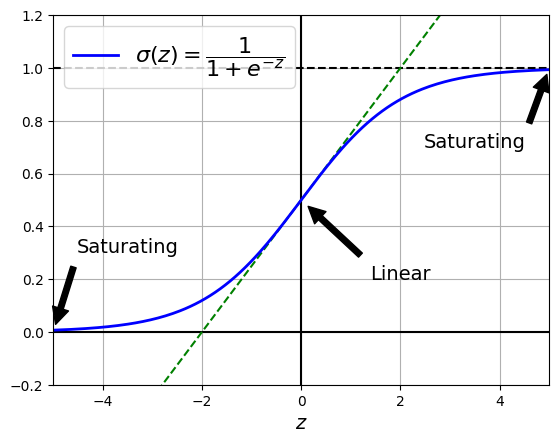

In [8]:
# extra code – this cell generates Figure 11–1

import numpy as np

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

z = np.linspace(-5, 5, 200)

plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [1, 1], 'k--')
plt.plot([0, 0], [-0.2, 1.2], 'k-')
plt.plot([-5, 5], [-3/4, 7/4], 'g--')
plt.plot(z, sigmoid(z), "b-", linewidth=2,
         label=r"$\sigma(z) = \dfrac{1}{1+e^{-z}}$")
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Saturating', xytext=(3.5, 0.7), xy=(5, 1), arrowprops=props,
             fontsize=14, ha="center")
plt.annotate('Saturating', xytext=(-3.5, 0.3), xy=(-5, 0), arrowprops=props,
             fontsize=14, ha="center")
plt.annotate('Linear', xytext=(2, 0.2), xy=(0, 0.5), arrowprops=props,
             fontsize=14, ha="center")
plt.grid(True)
plt.axis([-5, 5, -0.2, 1.2])
plt.xlabel("$z$")
plt.legend(loc="upper left", fontsize=16)

plt.show()

## Glorot and He Initialization

In [9]:
import torch
import torch.nn as nn

layer = nn.Linear(40, 10)
layer.weight.data *= 6 ** 0.5  # Kaiming init (or 3 ** 0.5 for LeCun init)
torch.zero_(layer.bias.data)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [10]:
layer = nn.Linear(40, 10)
nn.init.kaiming_uniform_(layer.weight)
nn.init.zeros_(layer.bias)

Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], requires_grad=True)

In [11]:
def use_he_init(module):
    if isinstance(module, nn.Linear):
        nn.init.kaiming_uniform_(module.weight)
        nn.init.zeros_(module.bias)

model = nn.Sequential(nn.Linear(50, 40), nn.ReLU(), nn.Linear(40, 1), nn.ReLU())
model.apply(use_he_init)

Sequential(
  (0): Linear(in_features=50, out_features=40, bias=True)
  (1): ReLU()
  (2): Linear(in_features=40, out_features=1, bias=True)
  (3): ReLU()
)

In [12]:
model = nn.Sequential(nn.Linear(50, 40), nn.LeakyReLU(negative_slope=0.2))
model.apply(use_he_init)

Sequential(
  (0): Linear(in_features=50, out_features=40, bias=True)
  (1): LeakyReLU(negative_slope=0.2)
)

## Better Activation Functions

### Leaky ReLU

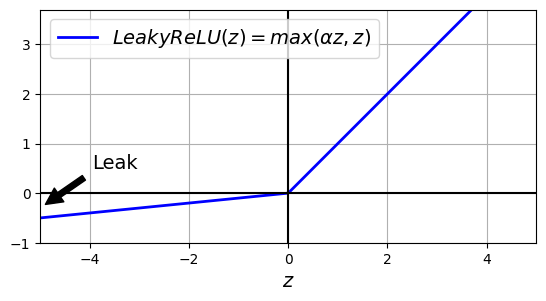

In [13]:
# extra code – this cell generates Figure 11–2

def leaky_relu(z, alpha):
    return np.maximum(alpha * z, z)

z = np.linspace(-5, 5, 200)
plt.plot(z, leaky_relu(z, 0.1), "b-", linewidth=2, label=r"$LeakyReLU(z) = max(\alpha z, z)$")
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([0, 0], [-1, 3.7], 'k-')
plt.grid(True)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Leak', xytext=(-3.5, 0.5), xy=(-5, -0.3), arrowprops=props,
             fontsize=14, ha="center")
plt.xlabel("$z$")
plt.axis([-5, 5, -1, 3.7])
plt.gca().set_aspect("equal")
plt.legend()

plt.show()

In [14]:
torch.manual_seed(42)
alpha = 0.2
model = nn.Sequential(nn.Linear(50, 40), nn.LeakyReLU(negative_slope=alpha))
nn.init.kaiming_uniform_(model[0].weight, alpha, nonlinearity="leaky_relu")
model(torch.rand(2, 50)).shape

torch.Size([2, 40])

### ELU

Implementing ELU in PyTorch is trivial, just add an `ELU` layer after each `Linear` layer in your model, and make sure to use Kaiming initialization for these `Linear` layers:

In [15]:
torch.manual_seed(42)
model = nn.Sequential(nn.Linear(50, 40), nn.ELU())
nn.init.kaiming_uniform_(model[0].weight)
model(torch.rand(2, 50)).shape

torch.Size([2, 40])

### SELU

By default, the SELU hyperparameters (`scale` and `alpha`) are tuned in such a way that the mean output of each neuron remains close to 0, and the standard deviation remains close to 1 (assuming the inputs are standardized with mean 0 and standard deviation 1 too, and other constraints are respected, as explained in the book). Using this activation function, even a 1,000 layer deep neural network preserves roughly mean 0 and standard deviation 1 across all layers, avoiding the exploding/vanishing gradients problem:

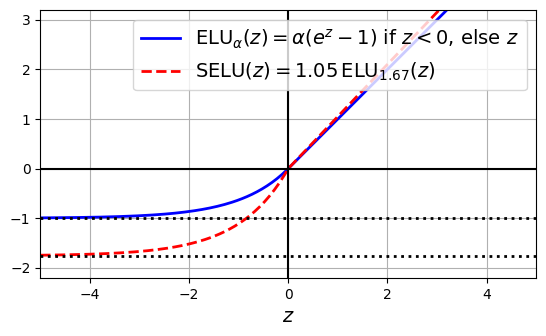

In [16]:
# extra code – this cell generates Figure 11–3

from scipy.special import erfc

# alpha and scale to self normalize with mean 0 and standard deviation 1
# (see equation 14 in the paper):
alpha_0_1 = -np.sqrt(2 / np.pi) / (erfc(1 / np.sqrt(2)) * np.exp(1 / 2) - 1)
scale_0_1 = (
    (1 - erfc(1 / np.sqrt(2)) * np.sqrt(np.e))
    * np.sqrt(2 * np.pi)
    * (
        2 * erfc(np.sqrt(2)) * np.e ** 2
        + np.pi * erfc(1 / np.sqrt(2)) ** 2 * np.e
        - 2 * (2 + np.pi) * erfc(1 / np.sqrt(2)) * np.sqrt(np.e)
        + np.pi
        + 2
    ) ** (-1 / 2)
)

def elu(z, alpha=1):
    return np.where(z < 0, alpha * (np.exp(z) - 1), z)

def selu(z, scale=scale_0_1, alpha=alpha_0_1):
    return scale * elu(z, alpha)

z = np.linspace(-5, 5, 200)
plt.plot(z, elu(z), "b-", linewidth=2, label=r"ELU$_\alpha(z) = \alpha (e^z - 1)$ if $z < 0$, else $z$")
plt.plot(z, selu(z), "r--", linewidth=2, label=r"SELU$(z) = 1.05 \, $ELU$_{1.67}(z)$")
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1, -1], 'k:', linewidth=2)
plt.plot([-5, 5], [-1.758, -1.758], 'k:', linewidth=2)
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.axis([-5, 5, -2.2, 3.2])
plt.xlabel("$z$")
plt.gca().set_aspect("equal")
plt.legend()

plt.show()

Using SELU is straightforward:

In [17]:
torch.manual_seed(42)
model = nn.Sequential(nn.Linear(50, 40), nn.SELU())
nn.init.kaiming_uniform_(model[0].weight)
model(torch.rand(2, 50)).shape

torch.Size([2, 40])

### GELU, Swish, SwiGLU, Mish, and ReLU²

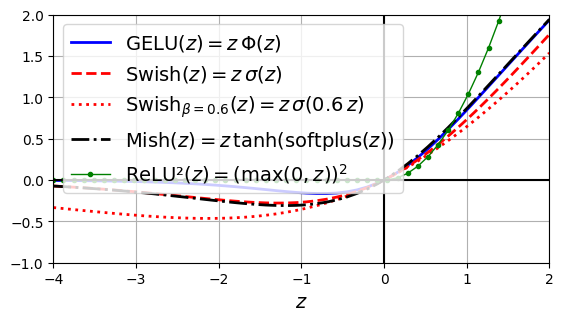

In [18]:
# extra code – this cell generates Figure 11–4

def swish(z, beta=1):
    return z * sigmoid(beta * z)

def approx_gelu(z):
    return swish(z, beta=1.702)

def softplus(z):
    return np.log(1 + np.exp(z))

def mish(z):
    return z * np.tanh(softplus(z))

def relu_squared(z):
    return np.maximum(0, z)**2

z = np.linspace(-4, 2, 50)

beta = 0.6
plt.plot(z, approx_gelu(z), "b-", linewidth=2,
         label=r"GELU$(z) = z\,\Phi(z)$")
plt.plot(z, swish(z), "r--", linewidth=2,
         label=r"Swish$(z) = z\,\sigma(z)$")
plt.plot(z, swish(z, beta), "r:", linewidth=2,
         label=fr"Swish$_{{\beta={beta}}}(z)=z\,\sigma({beta}\,z)$")
plt.plot(z, mish(z), "k-.", linewidth=2,
         label=fr"Mish$(z) = z\,\tanh($softplus$(z))$")
plt.plot(z, relu_squared(z), "g.-", linewidth=1,
         label=fr"ReLU²$(z) = (\max(0, z))^2$")
plt.plot([-4, 2], [0, 0], 'k-')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.axis([-4, 2, -1, 2])
plt.gca().set_aspect("equal")
plt.xlabel("$z$")
plt.legend(loc="upper left")

plt.show()

**SwiGLU**

In [19]:
class SwiGLU(nn.Module):
    def __init__(self, beta=1.0):
        super().__init__()
        self.beta = beta

    def forward(self, x):
        z1, z2 = x.chunk(2, dim=-1)
        param_swish = z1 * torch.sigmoid(self.beta * z1)
        return param_swish * z2

torch.manual_seed(42)
model = nn.Sequential(nn.Linear(50, 2 * 40), SwiGLU(beta=0.2))
nn.init.kaiming_uniform_(model[0].weight)
model(torch.rand(2, 50)).shape

torch.Size([2, 40])

**ReLU<sup>2</sup>**

In [20]:
import torch.nn.functional as F

class ReLU2(nn.Module):
    def forward(self, x):
        return F.relu(x).square()

torch.manual_seed(42)
model = nn.Sequential(nn.Linear(50, 40), ReLU2())
nn.init.kaiming_uniform_(model[0].weight)
model(torch.rand(2, 50)).shape

torch.Size([2, 40])

## Batch Normalization

With the BN layers after the activation functions:

In [21]:
torch.manual_seed(42)

model = nn.Sequential(
    nn.Flatten(),
    nn.BatchNorm1d(1 * 28 * 28),
    nn.Linear(1 * 28 * 28, 300),
    nn.ReLU(),
    nn.BatchNorm1d(300),
    nn.Linear(300, 100),
    nn.ReLU(),
    nn.BatchNorm1d(100),
    nn.Linear(100, 10)
)

In [22]:
dict(model[1].named_parameters()).keys()

dict_keys(['weight', 'bias'])

In [23]:
dict(model[1].named_buffers()).keys()

dict_keys(['running_mean', 'running_var', 'num_batches_tracked'])

Quite often, applying BN before the activation function works better. Moreover, the `Linear` layer before a `BatchNorm1d` layer does not need to have bias terms, since the `BatchNorm1d` layer has some as well. So you can set `bias=False` when creating those layers:

In [24]:
torch.manual_seed(42)

model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(1 * 28 * 28, 300, bias=False),
    nn.BatchNorm1d(300),
    nn.ReLU(),
    nn.Linear(300, 100, bias=False),
    nn.BatchNorm1d(100),
    nn.ReLU(),
    nn.Linear(100, 10)
)

## Layer Normalization

In [25]:
torch.manual_seed(42)

inputs = torch.randn(32, 3, 100, 200)  # a batch of random RGB images
layer_norm = nn.LayerNorm([100, 200])
result = layer_norm(inputs)  # normalizes over the last two dimensions

In [26]:
means = inputs.mean(dim=[2, 3], keepdim=True)
vars_ = inputs.var(dim=[2, 3], keepdim=True, unbiased=False)
stds = torch.sqrt(vars_ + layer_norm.eps)
result2 = layer_norm.weight * (inputs - means) / stds + layer_norm.bias
assert torch.allclose(result, result2)

In [27]:
layer_norm = nn.LayerNorm([3, 100, 200])
result = layer_norm(inputs)  # normalizes over the last three dimensions

## Gradient Clipping

See the line `nn.utils.clip_grad_norm_(...)` in the training function in the next section.

# Reusing Pretrained Layers

## Transfer Learning with PyTorch

Let's split the fashion MNIST training set in two:
* `X_train_A`: all images of all items except for T-shirts/tops and pullovers (classes 0 and 2).
* `X_train_B`: a much smaller training set of just the first 20 images of T-shirts/tops and pullovers.

The validation set and the test set are also split this way, but without restricting the number of images.

We will train a model on set A (classification task with 8 classes), and try to reuse it to tackle set B (binary classification). We hope to transfer a little bit of knowledge from task A to task B, since classes in set A (trousers, dresses, coats, sandals, shirts, sneakers, bags, and ankle boots) are somewhat similar to classes in set B (T-shirts/tops and pullovers). However, since we are using `Linear` layers, only patterns that occur at the same location can be reused (in contrast, convolutional layers will transfer much better, since learned patterns can be detected anywhere on the image, as we will see in the chapter 12).

Let's fetch the Fashion MNIST data and split it into datasets A and B:

In [28]:
from torch.utils.data import TensorDataset, DataLoader
from sklearn.datasets import fetch_openml

fashion_mnist = fetch_openml(name="Fashion-MNIST", as_frame=False)
X = torch.FloatTensor(fashion_mnist.data.reshape(-1, 1, 28, 28) / 255.)
y = torch.from_numpy(fashion_mnist.target.astype(int))
in_B = (y == 0) | (y == 2)  # Pullover or T-shirt/top
X_A, y_A = X[~in_B], y[~in_B]
y_A = torch.maximum(y_A - 2, torch.tensor(0))  # [1,3,4,5,6,7,8,9] => [0,..,7]
X_B, y_B = X[in_B], (y[in_B] == 2).to(dtype=torch.float32).view(-1, 1)

train_set_A = TensorDataset(X_A[:-7_000], y_A[:-7000])
valid_set_A = TensorDataset(X_A[-7_000:-5000], y_A[-7000:-5000])
test_set_A = TensorDataset(X_A[-5_000:], y_A[-5000:])
train_set_B = TensorDataset(X_B[:20], y_B[:20])
valid_set_B = TensorDataset(X_B[20:5000], y_B[20:5000])
test_set_B = TensorDataset(X_B[5_000:], y_B[5000:])

train_loader_A = DataLoader(train_set_A, batch_size=32, shuffle=True)
valid_loader_A = DataLoader(valid_set_A, batch_size=32)
test_loader_A = DataLoader(test_set_A, batch_size=32)
train_loader_B = DataLoader(train_set_B, batch_size=32, shuffle=True)
valid_loader_B = DataLoader(valid_set_B, batch_size=32)
test_loader_B = DataLoader(test_set_B, batch_size=32)

Let's define the `evaluate_tm()` and `train()` functions, much like in Chapter 10:

In [29]:
import torchmetrics

def evaluate_tm(model, data_loader, metric):
    model.eval()
    metric.reset()
    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_pred = model(X_batch)
            metric.update(y_pred, y_batch)
    return metric.compute()

def train(model, optimizer, loss_fn, metric, train_loader, valid_loader,
          n_epochs):
    history = {"train_losses": [], "train_metrics": [], "valid_metrics": []}
    for epoch in range(n_epochs):
        total_loss = 0.0
        metric.reset()
        model.train()
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            total_loss += loss.item()
            loss.backward()
            # Uncomment to activate gradient clipping:
            #nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            optimizer.zero_grad()
            metric.update(y_pred, y_batch)
        history["train_losses"].append(total_loss / len(train_loader))
        history["train_metrics"].append(metric.compute().item())
        history["valid_metrics"].append(
            evaluate_tm(model, valid_loader, metric).item())
        print(f"Epoch {epoch + 1}/{n_epochs}, "
              f"train loss: {history['train_losses'][-1]:.4f}, "
              f"train metric: {history['train_metrics'][-1]:.4f}, "
              f"valid metric: {history['valid_metrics'][-1]:.4f}")
    return history

Let's define our first model for task A:

In [30]:
torch.manual_seed(42)

model_A = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28 * 28, 100),
    nn.ReLU(),
    nn.Linear(100, 100),
    nn.ReLU(),
    nn.Linear(100, 100),
    nn.ReLU(),
    nn.Linear(100, 8)
)
model_A = model_A.to(device)

In [31]:
model_A.apply(use_he_init)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=100, bias=True)
  (2): ReLU()
  (3): Linear(in_features=100, out_features=100, bias=True)
  (4): ReLU()
  (5): Linear(in_features=100, out_features=100, bias=True)
  (6): ReLU()
  (7): Linear(in_features=100, out_features=8, bias=True)
)

In [32]:
n_epochs = 20
optimizer = torch.optim.SGD(model_A.parameters(), lr=0.005)
xentropy = nn.CrossEntropyLoss()
accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=8).to(device)
history_A = train(model_A, optimizer, xentropy, accuracy,
                  train_loader_A, valid_loader_A, n_epochs)

Epoch 1/20, train loss: 0.6363, train metric: 0.7845, valid metric: 0.8390
Epoch 2/20, train loss: 0.3525, train metric: 0.8790, valid metric: 0.8880
Epoch 3/20, train loss: 0.3054, train metric: 0.8943, valid metric: 0.8975
Epoch 4/20, train loss: 0.2811, train metric: 0.9007, valid metric: 0.8320
Epoch 5/20, train loss: 0.2652, train metric: 0.9073, valid metric: 0.8915
Epoch 6/20, train loss: 0.2519, train metric: 0.9125, valid metric: 0.8950
Epoch 7/20, train loss: 0.2397, train metric: 0.9162, valid metric: 0.8910
Epoch 8/20, train loss: 0.2317, train metric: 0.9194, valid metric: 0.9075
Epoch 9/20, train loss: 0.2234, train metric: 0.9224, valid metric: 0.9015
Epoch 10/20, train loss: 0.2149, train metric: 0.9248, valid metric: 0.9040
Epoch 11/20, train loss: 0.2098, train metric: 0.9276, valid metric: 0.9150
Epoch 12/20, train loss: 0.2029, train metric: 0.9286, valid metric: 0.8985
Epoch 13/20, train loss: 0.1982, train metric: 0.9305, valid metric: 0.9210
Epoch 14/20, train lo

In [33]:
torch.manual_seed(9)

model_B = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28 * 28, 100),
    nn.ReLU(),
    nn.Linear(100, 100),
    nn.ReLU(),
    nn.Linear(100, 100),
    nn.ReLU(),
    nn.Linear(100, 1)
).to(device)

In [34]:
model_B.apply(use_he_init)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=100, bias=True)
  (2): ReLU()
  (3): Linear(in_features=100, out_features=100, bias=True)
  (4): ReLU()
  (5): Linear(in_features=100, out_features=100, bias=True)
  (6): ReLU()
  (7): Linear(in_features=100, out_features=1, bias=True)
)

In [35]:
n_epochs = 20
optimizer = torch.optim.SGD(model_B.parameters(), lr=0.005)
xentropy = nn.BCEWithLogitsLoss()
accuracy = torchmetrics.Accuracy(task="binary").to(device)
history_B = train(model_B, optimizer, xentropy, accuracy,
                  train_loader_B, valid_loader_B, n_epochs)

Epoch 1/20, train loss: 1.1117, train metric: 0.4000, valid metric: 0.5032
Epoch 2/20, train loss: 0.8887, train metric: 0.4000, valid metric: 0.5036
Epoch 3/20, train loss: 0.7477, train metric: 0.4000, valid metric: 0.5181
Epoch 4/20, train loss: 0.6618, train metric: 0.4000, valid metric: 0.5823
Epoch 5/20, train loss: 0.6067, train metric: 0.4500, valid metric: 0.6705
Epoch 6/20, train loss: 0.5684, train metric: 0.6000, valid metric: 0.7588
Epoch 7/20, train loss: 0.5382, train metric: 0.7000, valid metric: 0.8062
Epoch 8/20, train loss: 0.5149, train metric: 0.9000, valid metric: 0.8359
Epoch 9/20, train loss: 0.4962, train metric: 0.9500, valid metric: 0.8512
Epoch 10/20, train loss: 0.4804, train metric: 0.9500, valid metric: 0.8606
Epoch 11/20, train loss: 0.4671, train metric: 0.9500, valid metric: 0.8651
Epoch 12/20, train loss: 0.4553, train metric: 0.9500, valid metric: 0.8697
Epoch 13/20, train loss: 0.4448, train metric: 0.9500, valid metric: 0.8731
Epoch 14/20, train lo

In [36]:
evaluate_tm(model_B, test_loader_B, accuracy)

tensor(0.8860, device='cuda:0')

In [37]:
import copy

torch.manual_seed(43)
reused_layers = copy.deepcopy(model_A[:-1])
model_B_on_A = nn.Sequential(
    *reused_layers,
    nn.Linear(100, 1)  # new output layer for task B
).to(device)

In [38]:
for layer in model_B_on_A[:-1]:
    for param in layer.parameters():
        param.requires_grad = False

In [39]:
n_epochs = 10
optimizer = torch.optim.SGD(model_B_on_A.parameters(), lr=0.005)
xentropy = nn.BCEWithLogitsLoss()
accuracy = torchmetrics.Accuracy(task="binary").to(device)
history_B = train(model_B_on_A, optimizer, xentropy, accuracy,
                  train_loader_B, valid_loader_B, n_epochs)

Epoch 1/10, train loss: 0.8847, train metric: 0.4000, valid metric: 0.4723
Epoch 2/10, train loss: 0.7920, train metric: 0.3000, valid metric: 0.4886
Epoch 3/10, train loss: 0.7442, train metric: 0.2000, valid metric: 0.5600
Epoch 4/10, train loss: 0.7154, train metric: 0.4500, valid metric: 0.6145
Epoch 5/10, train loss: 0.6941, train metric: 0.5500, valid metric: 0.6424
Epoch 6/10, train loss: 0.6760, train metric: 0.6500, valid metric: 0.6562
Epoch 7/10, train loss: 0.6594, train metric: 0.7000, valid metric: 0.6733
Epoch 8/10, train loss: 0.6438, train metric: 0.7000, valid metric: 0.6948
Epoch 9/10, train loss: 0.6290, train metric: 0.7000, valid metric: 0.7169
Epoch 10/10, train loss: 0.6148, train metric: 0.7500, valid metric: 0.7434


In [40]:
for layer in model_B_on_A[2:]:
    for param in layer.parameters():
        param.requires_grad = True

In [41]:
n_epochs = 20
optimizer = torch.optim.SGD(model_B_on_A.parameters(), lr=0.005)
xentropy = nn.BCEWithLogitsLoss()
accuracy = torchmetrics.Accuracy(task="binary").to(device)
history_B = train(model_B_on_A, optimizer, xentropy, accuracy,
                  train_loader_B, valid_loader_B, n_epochs)

Epoch 1/20, train loss: 0.6011, train metric: 0.7500, valid metric: 0.7709
Epoch 2/20, train loss: 0.5841, train metric: 0.7500, valid metric: 0.7994
Epoch 3/20, train loss: 0.5680, train metric: 0.7500, valid metric: 0.8247
Epoch 4/20, train loss: 0.5528, train metric: 0.7500, valid metric: 0.8418
Epoch 5/20, train loss: 0.5384, train metric: 0.8000, valid metric: 0.8572
Epoch 6/20, train loss: 0.5246, train metric: 0.8500, valid metric: 0.8711
Epoch 7/20, train loss: 0.5115, train metric: 0.8500, valid metric: 0.8831
Epoch 8/20, train loss: 0.4990, train metric: 0.9500, valid metric: 0.8878
Epoch 9/20, train loss: 0.4871, train metric: 0.9500, valid metric: 0.8964
Epoch 10/20, train loss: 0.4757, train metric: 0.9500, valid metric: 0.9024
Epoch 11/20, train loss: 0.4648, train metric: 0.9500, valid metric: 0.9064
Epoch 12/20, train loss: 0.4544, train metric: 0.9500, valid metric: 0.9100
Epoch 13/20, train loss: 0.4444, train metric: 0.9500, valid metric: 0.9127
Epoch 14/20, train lo

So, what's the final verdict?

In [42]:
evaluate_tm(model_B_on_A, test_loader_B, accuracy)

tensor(0.9312, device='cuda:0')

# Faster Optimizers

In [43]:
# extra code – a little function to test an optimizer on Fashion MNIST

train_set = TensorDataset(X[:55_000], y[:55_000])
valid_set = TensorDataset(X[55_000:60_000], y[55_000:60_000])
test_set = TensorDataset(X[60_000:], y[60_000:])

def build_model(seed=42):
    torch.manual_seed(seed)
    model = nn.Sequential(
        nn.Flatten(),
        nn.Linear(28 * 28, 100),
        nn.ReLU(),
        nn.Linear(100, 100),
        nn.ReLU(),
        nn.Linear(100, 100),
        nn.ReLU(),
        nn.Linear(100, 10)
    ).to(device)
    model.apply(use_he_init)
    return model

def test_optimizer(model, optimizer, n_epochs=10, batch_size=32):
    train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
    valid_loader = DataLoader(valid_set, batch_size=32)
    test_loader = DataLoader(test_set, batch_size=32)
    xentropy = nn.CrossEntropyLoss()
    accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=10)
    history = train(model, optimizer, xentropy, accuracy.to(device),
                    train_loader, valid_loader, n_epochs)
    return history, evaluate_tm(model, test_loader, accuracy)

In [44]:
model = build_model()  # extra code
optimizer = torch.optim.SGD(model.parameters(), lr=0.05)
history_sgd, acc_sgd = test_optimizer(model, optimizer)  # extra code

Epoch 1/10, train loss: 0.5710, train metric: 0.7930, valid metric: 0.8436
Epoch 2/10, train loss: 0.4024, train metric: 0.8530, valid metric: 0.8508
Epoch 3/10, train loss: 0.3620, train metric: 0.8669, valid metric: 0.8692
Epoch 4/10, train loss: 0.3366, train metric: 0.8762, valid metric: 0.8702
Epoch 5/10, train loss: 0.3174, train metric: 0.8831, valid metric: 0.8738
Epoch 6/10, train loss: 0.3030, train metric: 0.8870, valid metric: 0.8712
Epoch 7/10, train loss: 0.2906, train metric: 0.8913, valid metric: 0.8772
Epoch 8/10, train loss: 0.2807, train metric: 0.8957, valid metric: 0.8784
Epoch 9/10, train loss: 0.2715, train metric: 0.8978, valid metric: 0.8786
Epoch 10/10, train loss: 0.2622, train metric: 0.9016, valid metric: 0.8710


## Momentum optimization

In [45]:
model = build_model()  # extra code
optimizer = torch.optim.SGD(model.parameters(), momentum=0.9, lr=0.05)
history_momentum, acc_momentum = test_optimizer(model, optimizer)  # extra code

Epoch 1/10, train loss: 0.6026, train metric: 0.7829, valid metric: 0.7866
Epoch 2/10, train loss: 0.4777, train metric: 0.8300, valid metric: 0.8430
Epoch 3/10, train loss: 0.4487, train metric: 0.8408, valid metric: 0.8334
Epoch 4/10, train loss: 0.4336, train metric: 0.8457, valid metric: 0.8458
Epoch 5/10, train loss: 0.4053, train metric: 0.8559, valid metric: 0.8426
Epoch 6/10, train loss: 0.3997, train metric: 0.8572, valid metric: 0.8604
Epoch 7/10, train loss: 0.3934, train metric: 0.8586, valid metric: 0.8442
Epoch 8/10, train loss: 0.3789, train metric: 0.8647, valid metric: 0.8556
Epoch 9/10, train loss: 0.3758, train metric: 0.8662, valid metric: 0.8598
Epoch 10/10, train loss: 0.3676, train metric: 0.8689, valid metric: 0.8582


## Nesterov Accelerated Gradient

In [46]:
model = build_model()  # extra code
optimizer = torch.optim.SGD(model.parameters(),
                            momentum=0.9, nesterov=True, lr=0.05)
history_nesterov, acc_nesterov = test_optimizer(model, optimizer)  # extra code

Epoch 1/10, train loss: 0.5486, train metric: 0.8048, valid metric: 0.8118
Epoch 2/10, train loss: 0.4340, train metric: 0.8454, valid metric: 0.8336
Epoch 3/10, train loss: 0.4070, train metric: 0.8564, valid metric: 0.8490
Epoch 4/10, train loss: 0.3842, train metric: 0.8629, valid metric: 0.8656
Epoch 5/10, train loss: 0.3756, train metric: 0.8661, valid metric: 0.8528
Epoch 6/10, train loss: 0.3681, train metric: 0.8690, valid metric: 0.8604
Epoch 7/10, train loss: 0.3570, train metric: 0.8733, valid metric: 0.8580
Epoch 8/10, train loss: 0.3524, train metric: 0.8752, valid metric: 0.8538
Epoch 9/10, train loss: 0.3428, train metric: 0.8764, valid metric: 0.8612
Epoch 10/10, train loss: 0.3372, train metric: 0.8799, valid metric: 0.8566


## AdaGrad

In [47]:
model = build_model()  # extra code
optimizer = torch.optim.Adagrad(model.parameters(), lr=0.05)
history_adagrad, acc_adagrad = test_optimizer(model, optimizer)  # extra code

Epoch 1/10, train loss: 0.5605, train metric: 0.8155, valid metric: 0.8612
Epoch 2/10, train loss: 0.3699, train metric: 0.8642, valid metric: 0.8678
Epoch 3/10, train loss: 0.3351, train metric: 0.8762, valid metric: 0.8742
Epoch 4/10, train loss: 0.3142, train metric: 0.8835, valid metric: 0.8788
Epoch 5/10, train loss: 0.2982, train metric: 0.8888, valid metric: 0.8802
Epoch 6/10, train loss: 0.2865, train metric: 0.8928, valid metric: 0.8788
Epoch 7/10, train loss: 0.2745, train metric: 0.8973, valid metric: 0.8816
Epoch 8/10, train loss: 0.2663, train metric: 0.9001, valid metric: 0.8802
Epoch 9/10, train loss: 0.2582, train metric: 0.9036, valid metric: 0.8864
Epoch 10/10, train loss: 0.2511, train metric: 0.9060, valid metric: 0.8864


## RMSProp

In [48]:
model = build_model()  # extra code
optimizer = torch.optim.RMSprop(model.parameters(), alpha=0.9, lr=0.05)
history_rmsprop, acc_rmsprop = test_optimizer(model, optimizer)  # extra code

Epoch 1/10, train loss: 3.0856, train metric: 0.4135, valid metric: 0.4846
Epoch 2/10, train loss: 1.5592, train metric: 0.4054, valid metric: 0.3360
Epoch 3/10, train loss: 1.5156, train metric: 0.4150, valid metric: 0.4274
Epoch 4/10, train loss: 1.4835, train metric: 0.4209, valid metric: 0.4244
Epoch 5/10, train loss: 1.5939, train metric: 0.3872, valid metric: 0.4278
Epoch 6/10, train loss: 1.5009, train metric: 0.4204, valid metric: 0.4074
Epoch 7/10, train loss: 1.5294, train metric: 0.3967, valid metric: 0.3342
Epoch 8/10, train loss: 1.7418, train metric: 0.3270, valid metric: 0.2402
Epoch 9/10, train loss: 1.6990, train metric: 0.3328, valid metric: 0.2942
Epoch 10/10, train loss: 1.7721, train metric: 0.3072, valid metric: 0.2708


## Adam Optimization

In [49]:
model = build_model()  # extra code
optimizer = torch.optim.Adam(model.parameters(), betas=(0.9, 0.999), lr=0.05)
history_adam, acc_adam = test_optimizer(model, optimizer)  # extra code

Epoch 1/10, train loss: 1.4496, train metric: 0.4273, valid metric: 0.4526
Epoch 2/10, train loss: 1.4728, train metric: 0.3854, valid metric: 0.3730
Epoch 3/10, train loss: 1.5609, train metric: 0.3434, valid metric: 0.2696
Epoch 4/10, train loss: 1.6008, train metric: 0.3061, valid metric: 0.3220
Epoch 5/10, train loss: 1.5894, train metric: 0.3120, valid metric: 0.3034
Epoch 6/10, train loss: 1.5993, train metric: 0.3094, valid metric: 0.2750
Epoch 7/10, train loss: 1.6083, train metric: 0.3085, valid metric: 0.3202
Epoch 8/10, train loss: 1.5974, train metric: 0.3136, valid metric: 0.3124
Epoch 9/10, train loss: 1.5901, train metric: 0.3151, valid metric: 0.3078
Epoch 10/10, train loss: 1.6109, train metric: 0.3166, valid metric: 0.2960


**Adamax Optimization**

In [50]:
model = build_model()  # extra code
optimizer = torch.optim.Adamax(model.parameters(), betas=(0.9, 0.999), lr=0.05)
history_adamax, acc_adamax = test_optimizer(model, optimizer)  # extra code

Epoch 1/10, train loss: 0.6799, train metric: 0.7774, valid metric: 0.7860
Epoch 2/10, train loss: 0.5126, train metric: 0.8211, valid metric: 0.8344
Epoch 3/10, train loss: 0.4768, train metric: 0.8340, valid metric: 0.8314
Epoch 4/10, train loss: 0.4550, train metric: 0.8395, valid metric: 0.8346
Epoch 5/10, train loss: 0.4363, train metric: 0.8462, valid metric: 0.8404
Epoch 6/10, train loss: 0.4283, train metric: 0.8491, valid metric: 0.8492
Epoch 7/10, train loss: 0.4228, train metric: 0.8508, valid metric: 0.8342
Epoch 8/10, train loss: 0.4126, train metric: 0.8555, valid metric: 0.8402
Epoch 9/10, train loss: 0.4131, train metric: 0.8538, valid metric: 0.8366
Epoch 10/10, train loss: 0.4032, train metric: 0.8580, valid metric: 0.8546


**Nadam Optimization**

In [51]:
model = build_model()  # extra code
optimizer = torch.optim.NAdam(model.parameters(), betas=(0.9, 0.999), lr=0.05)
history_nadam, acc_nadam = test_optimizer(model, optimizer)  # extra code

Epoch 1/10, train loss: 2.2631, train metric: 0.1478, valid metric: 0.1046
Epoch 2/10, train loss: 2.3083, train metric: 0.1001, valid metric: 0.0936
Epoch 3/10, train loss: 2.3078, train metric: 0.1013, valid metric: 0.1056
Epoch 4/10, train loss: 2.3082, train metric: 0.1011, valid metric: 0.0936
Epoch 5/10, train loss: 2.3080, train metric: 0.1010, valid metric: 0.0982
Epoch 6/10, train loss: 2.3081, train metric: 0.0988, valid metric: 0.1018
Epoch 7/10, train loss: 2.3096, train metric: 0.0987, valid metric: 0.1014
Epoch 8/10, train loss: 2.3039, train metric: 0.1033, valid metric: 0.0980
Epoch 9/10, train loss: 2.3086, train metric: 0.1017, valid metric: 0.0994
Epoch 10/10, train loss: 2.3088, train metric: 0.0985, valid metric: 0.1042


**AdamW Optimization**

In [52]:
model = build_model()  # extra code
optimizer = torch.optim.AdamW(model.parameters(), betas=(0.9, 0.999),
                              weight_decay=1e-5, lr=0.05)
history_adamw, acc_adamw = test_optimizer(model, optimizer)  # extra code

Epoch 1/10, train loss: 1.3913, train metric: 0.4717, valid metric: 0.3906
Epoch 2/10, train loss: 1.3219, train metric: 0.4384, valid metric: 0.2046
Epoch 3/10, train loss: 2.0523, train metric: 0.1827, valid metric: 0.1784
Epoch 4/10, train loss: 1.9033, train metric: 0.1929, valid metric: 0.1980
Epoch 5/10, train loss: 1.8830, train metric: 0.1940, valid metric: 0.1974
Epoch 6/10, train loss: 1.8693, train metric: 0.1953, valid metric: 0.2000
Epoch 7/10, train loss: 1.8585, train metric: 0.1736, valid metric: 0.0980
Epoch 8/10, train loss: 2.3188, train metric: 0.0994, valid metric: 0.1006
Epoch 9/10, train loss: 2.3152, train metric: 0.1022, valid metric: 0.0994
Epoch 10/10, train loss: 2.3120, train metric: 0.0975, valid metric: 0.1042


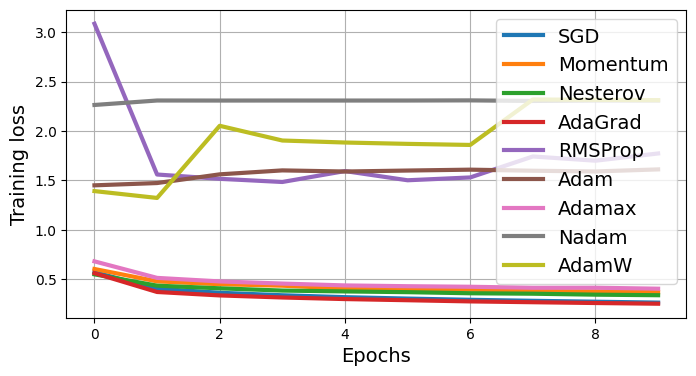

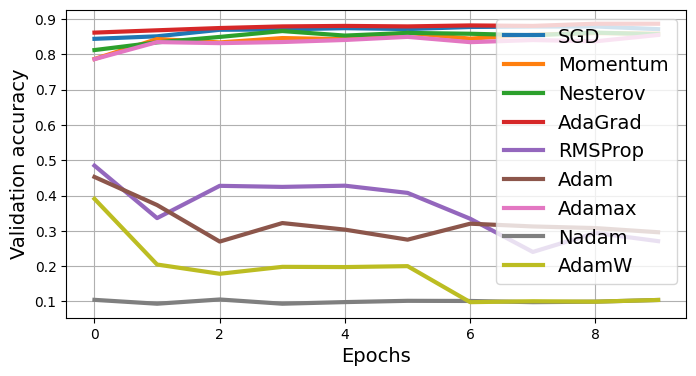

In [53]:
# extra code – visualize the learning curves of all the optimizers

for plot in ("train_losses", "valid_metrics"):
    plt.figure(figsize=(8, 4))
    opt_names = "SGD Momentum Nesterov AdaGrad RMSProp Adam Adamax Nadam AdamW"
    for history, opt_name in zip(
        (history_sgd, history_momentum, history_nesterov, history_adagrad,
         history_rmsprop, history_adam, history_adamax, history_nadam,
         history_adamw), opt_names.split()):
        plt.plot(history[plot], label=opt_name, linewidth=3)

    plt.grid()
    plt.xlabel("Epochs")
    plt.ylabel({"train_losses": "Training loss", "valid_metrics": "Validation accuracy"}[plot])
    plt.legend(loc="upper right")
    plt.show()

# Learning Rate Scheduling

In [54]:
model = build_model()  # extra code
optimizer = torch.optim.SGD(model.parameters(), lr=0.05)  # or any other optim.
exp_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

In [55]:
def train_with_scheduler(model, optimizer, loss_fn, metric, train_loader,
                         valid_loader, n_epochs, scheduler):
    history = {"train_losses": [], "train_metrics": [], "valid_metrics": []}
    for epoch in range(n_epochs):
        losses = []
        metric.reset()
        for X_batch, y_batch in train_loader:
            model.train()
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            losses.append(loss.item())
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            metric.update(y_pred, y_batch)
        history["train_losses"].append(np.mean(losses))
        history["train_metrics"].append(metric.compute().item())
        val_metric = evaluate_tm(model, valid_loader, metric).item()
        history["valid_metrics"].append(val_metric)
        print(f"Epoch {epoch + 1}/{n_epochs}, "
              f"train loss: {history['train_losses'][-1]:.4f}, "
              f"train metric: {history['train_metrics'][-1]:.4f}, "
              f"valid metric: {history['valid_metrics'][-1]:.4f}")
        if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
            scheduler.step(val_metric)
        else:
            scheduler.step()
        print(f"Learning rate: {scheduler.get_last_lr()[0]:.5f}")
    return history

def test_scheduler(model, optimizer, scheduler, n_epochs=10, batch_size=32):
    train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
    valid_loader = DataLoader(valid_set, batch_size=32)
    test_loader = DataLoader(test_set, batch_size=32)
    xentropy = nn.CrossEntropyLoss()
    metric = torchmetrics.Accuracy(task="multiclass", num_classes=10).to(device)
    history = train_with_scheduler(
        model, optimizer, xentropy, metric, train_loader, valid_loader,
        n_epochs, scheduler)
    return history, evaluate_tm(model, test_loader, metric)

In [56]:
history_exp, acc_exp = test_scheduler(model, optimizer, exp_scheduler)  # extra code

Epoch 1/10, train loss: 0.5710, train metric: 0.7930, valid metric: 0.8436
Learning rate: 0.04500
Epoch 2/10, train loss: 0.3981, train metric: 0.8549, valid metric: 0.8508
Learning rate: 0.04050
Epoch 3/10, train loss: 0.3563, train metric: 0.8692, valid metric: 0.8690
Learning rate: 0.03645
Epoch 4/10, train loss: 0.3296, train metric: 0.8786, valid metric: 0.8752
Learning rate: 0.03281
Epoch 5/10, train loss: 0.3096, train metric: 0.8865, valid metric: 0.8786
Learning rate: 0.02952
Epoch 6/10, train loss: 0.2933, train metric: 0.8909, valid metric: 0.8740
Learning rate: 0.02657
Epoch 7/10, train loss: 0.2802, train metric: 0.8963, valid metric: 0.8790
Learning rate: 0.02391
Epoch 8/10, train loss: 0.2689, train metric: 0.9011, valid metric: 0.8796
Learning rate: 0.02152
Epoch 9/10, train loss: 0.2594, train metric: 0.9036, valid metric: 0.8818
Learning rate: 0.01937
Epoch 10/10, train loss: 0.2489, train metric: 0.9081, valid metric: 0.8836
Learning rate: 0.01743


In [57]:
model = build_model()  # extra code
optimizer = torch.optim.SGD(model.parameters(), lr=0.05)  # or any other optim.
perf_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="max", patience=2, factor=0.1)

In [58]:
history_perf, acc_perf = test_scheduler(model, optimizer, perf_scheduler)  # extra code

Epoch 1/10, train loss: 0.5710, train metric: 0.7930, valid metric: 0.8436
Learning rate: 0.05000
Epoch 2/10, train loss: 0.4024, train metric: 0.8530, valid metric: 0.8508
Learning rate: 0.05000
Epoch 3/10, train loss: 0.3620, train metric: 0.8669, valid metric: 0.8692
Learning rate: 0.05000
Epoch 4/10, train loss: 0.3366, train metric: 0.8762, valid metric: 0.8702
Learning rate: 0.05000
Epoch 5/10, train loss: 0.3174, train metric: 0.8831, valid metric: 0.8738
Learning rate: 0.05000
Epoch 6/10, train loss: 0.3030, train metric: 0.8870, valid metric: 0.8712
Learning rate: 0.05000
Epoch 7/10, train loss: 0.2906, train metric: 0.8913, valid metric: 0.8772
Learning rate: 0.05000
Epoch 8/10, train loss: 0.2807, train metric: 0.8957, valid metric: 0.8784
Learning rate: 0.05000
Epoch 9/10, train loss: 0.2715, train metric: 0.8978, valid metric: 0.8786
Learning rate: 0.05000
Epoch 10/10, train loss: 0.2622, train metric: 0.9016, valid metric: 0.8710
Learning rate: 0.05000


In [59]:
model = build_model()  # extra code
optimizer = torch.optim.SGD(model.parameters(), lr=0.05)  # or any other optim.
warmup_scheduler = torch.optim.lr_scheduler.LinearLR(
    optimizer, start_factor=0.1, end_factor=1.0, total_iters=3)

The following scheduler is equivalent to the previous one:

In [60]:
model = build_model()  # extra code
optimizer = torch.optim.SGD(model.parameters(), lr=0.05)  # or any other optim.
warmup_scheduler = torch.optim.lr_scheduler.LambdaLR(
    optimizer,
    lambda epoch: (min(epoch, 3) / 3) * (1.0 - 0.1) + 0.1)

In [61]:
# extra code
def train_with_warmup(model, optimizer, loss_fn, metric, train_loader,
                      valid_loader, n_epochs, warmup_scheduler, scheduler):
    history = {"train_losses": [], "train_metrics": [], "valid_metrics": []}
    for epoch in range(n_epochs):

        warmup_scheduler.step()

        # extra code
        losses = []
        metric.reset()

        for X_batch, y_batch in train_loader:

            # extra code
            model.train()
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            losses.append(loss.item())
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            metric.update(y_pred, y_batch)
        history["train_losses"].append(np.mean(losses))
        history["train_metrics"].append(metric.compute().item())
        val_metric = evaluate_tm(model, valid_loader, metric).item()
        history["valid_metrics"].append(val_metric)
        print(f"Epoch {epoch + 1}/{n_epochs}, "
              f"train loss: {history['train_losses'][-1]:.4f}, "
              f"train metric: {history['train_metrics'][-1]:.4f}, "
              f"valid metric: {history['valid_metrics'][-1]:.4f}")

        if epoch >= 3:  # deactivate other scheduler(s) during warmup
            scheduler.step(val_metric)

        # extra code
        print(f"Learning rate: {scheduler.get_last_lr()[0]:.5f}")
    return history

def test_warmup_scheduler(model, optimizer, warmup_scheduler, scheduler,
                          n_epochs=10, batch_size=32):
    train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
    valid_loader = DataLoader(valid_set, batch_size=32)
    test_loader = DataLoader(test_set, batch_size=32)
    xentropy = nn.CrossEntropyLoss()
    metric = torchmetrics.Accuracy(task="multiclass", num_classes=10).to(device)
    history = train_with_warmup(
        model, optimizer, xentropy, metric, train_loader, valid_loader,
        n_epochs, warmup_scheduler, scheduler)
    return history, evaluate_tm(model, test_loader, metric)

In [62]:
perf_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="max", patience=2, factor=0.1)
test_warmup_scheduler(model, optimizer, warmup_scheduler, perf_scheduler,
                      n_epochs=10, batch_size=32)

Epoch 1/10, train loss: 0.6286, train metric: 0.7788, valid metric: 0.8356
Learning rate: 0.00500
Epoch 2/10, train loss: 0.4498, train metric: 0.8395, valid metric: 0.8394
Learning rate: 0.00500
Epoch 3/10, train loss: 0.4023, train metric: 0.8541, valid metric: 0.8656
Learning rate: 0.00500
Epoch 4/10, train loss: 0.3603, train metric: 0.8681, valid metric: 0.8708
Learning rate: 0.05000
Epoch 5/10, train loss: 0.3350, train metric: 0.8771, valid metric: 0.8734
Learning rate: 0.05000
Epoch 6/10, train loss: 0.3159, train metric: 0.8829, valid metric: 0.8694
Learning rate: 0.05000
Epoch 7/10, train loss: 0.3013, train metric: 0.8881, valid metric: 0.8768
Learning rate: 0.05000
Epoch 8/10, train loss: 0.2892, train metric: 0.8914, valid metric: 0.8700
Learning rate: 0.05000
Epoch 9/10, train loss: 0.2794, train metric: 0.8972, valid metric: 0.8758
Learning rate: 0.05000
Epoch 10/10, train loss: 0.2683, train metric: 0.8999, valid metric: 0.8730
Learning rate: 0.00500


({'train_losses': [np.float64(0.628603962564829),
   np.float64(0.44983716296067827),
   np.float64(0.40226908034193715),
   np.float64(0.36026787254883497),
   np.float64(0.33502112600763845),
   np.float64(0.3158586380473398),
   np.float64(0.3013238393468105),
   np.float64(0.28916015639823145),
   np.float64(0.2793934434249243),
   np.float64(0.26831843189075977)],
  'train_metrics': [0.7788363695144653,
   0.8395272493362427,
   0.8541272878646851,
   0.8681091070175171,
   0.8771272897720337,
   0.8828545212745667,
   0.8881454467773438,
   0.8914181590080261,
   0.8971818089485168,
   0.8998545408248901],
  'valid_metrics': [0.8356000185012817,
   0.8393999934196472,
   0.8655999898910522,
   0.8708000183105469,
   0.8733999729156494,
   0.8694000244140625,
   0.876800000667572,
   0.8700000047683716,
   0.8758000135421753,
   0.8730000257492065]},
 tensor(0.8653, device='cuda:0'))

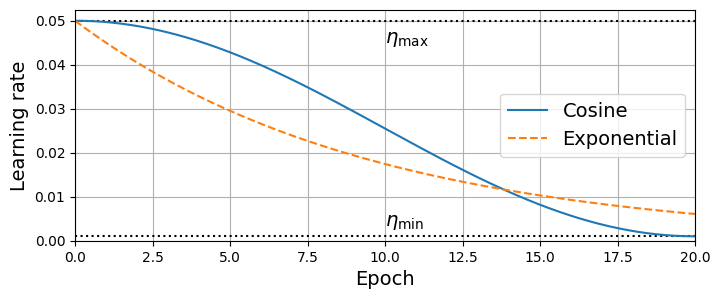

In [63]:
t = np.linspace(0, 20, 400)
eta_min = 0.001
eta_max = 0.05
t2 = 20
eta_cos_t = eta_min + 0.5 * (eta_max - eta_min) * (1 + np.cos(t / t2 * np.pi))
eta_exp_t = 0.9 ** t * eta_max

plt.figure(figsize=(8, 3))
plt.hlines([eta_min, eta_max], 0, 20, color="k", linestyle="dotted")
plt.plot(t, eta_cos_t, label="Cosine")
plt.plot(t, eta_exp_t, "--", label="Exponential")
plt.legend(loc="center right")
plt.text(10, eta_min + 0.0025, r"$\eta_\text{min}$")
plt.text(10, eta_max - 0.005, r"$\eta_\text{max}$")
plt.axis([0, 20, 0, eta_max * 1.05])
plt.grid(True)
plt.xlabel("Epoch")
plt.ylabel("Learning rate")
plt.show()

In [64]:
model = build_model()  # extra code
optimizer = torch.optim.SGD(model.parameters(), lr=0.05)  # or any other optim.
cosine_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer, T_max=20, eta_min=0.001)

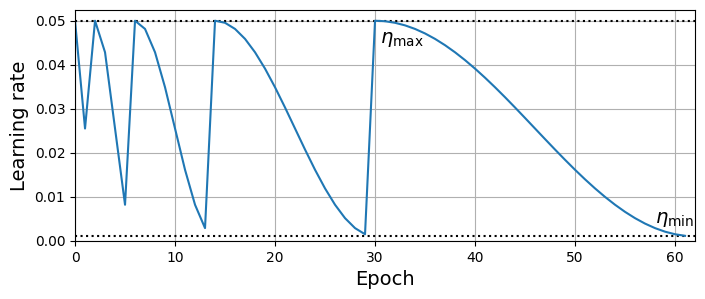

In [65]:
model = build_model()  # extra code
optimizer = torch.optim.SGD(model.parameters(), lr=0.05)  # or any other optim.
cosine_repeat_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, T_0=2, T_mult=2, eta_min=0.001)

lrs = []
for epoch in range(62):
    lrs.append(cosine_repeat_scheduler.get_last_lr()[0])
    cosine_repeat_scheduler.step()

plt.figure(figsize=(8, 3))
plt.hlines([eta_min, eta_max], 0, 64, color="k", linestyle="dotted")
plt.plot(lrs, label="Cosine")
plt.text(30.5, eta_max - 0.005, r"$\eta_\text{max}$")
plt.text(58, eta_min + 0.003, r"$\eta_\text{min}$")
plt.axis([0, 62, 0, eta_max * 1.05])
plt.grid(True)
plt.xlabel("Epoch")
plt.ylabel("Learning rate")
plt.show()

Let's list all the schedulers and link to their documentation page:

In [66]:
import re

DOCS_URL = "https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler"
for name in sorted(dir(torch.optim.lr_scheduler)):
    scheduler = getattr(torch.optim.lr_scheduler, name)
    if (not name.startswith("_") and isinstance(scheduler, type) and
        issubclass(scheduler, torch.optim.lr_scheduler.LRScheduler)):
            print(f"• {DOCS_URL}.{name}.html")

• https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.ChainedScheduler.html
• https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.ConstantLR.html
• https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.CosineAnnealingLR.html
• https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.CosineAnnealingWarmRestarts.html
• https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.CyclicLR.html
• https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.ExponentialLR.html
• https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.LRScheduler.html
• https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.LambdaLR.html
• https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.LinearLR.html
• https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.MultiStepLR.html
• https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.MultiplicativeLR.html
• https://pytorch.org/docs/sta

# Avoiding Overfitting Through Regularization

## ℓ₁ and ℓ₂ regularization

In [67]:
model = build_model()  # extra code
optimizer = torch.optim.SGD(model.parameters(), lr=0.05, weight_decay=1e-4)
history = test_optimizer(model, optimizer)

Epoch 1/10, train loss: 0.5705, train metric: 0.7923, valid metric: 0.8528
Epoch 2/10, train loss: 0.4025, train metric: 0.8528, valid metric: 0.8410
Epoch 3/10, train loss: 0.3616, train metric: 0.8663, valid metric: 0.8688
Epoch 4/10, train loss: 0.3377, train metric: 0.8747, valid metric: 0.8734
Epoch 5/10, train loss: 0.3189, train metric: 0.8828, valid metric: 0.8766
Epoch 6/10, train loss: 0.3050, train metric: 0.8865, valid metric: 0.8714
Epoch 7/10, train loss: 0.2927, train metric: 0.8907, valid metric: 0.8780
Epoch 8/10, train loss: 0.2823, train metric: 0.8946, valid metric: 0.8846
Epoch 9/10, train loss: 0.2745, train metric: 0.8972, valid metric: 0.8788
Epoch 10/10, train loss: 0.2641, train metric: 0.9015, valid metric: 0.8666


In [68]:
n_epochs = 3
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
loss_fn = nn.CrossEntropyLoss()

model = build_model()  # extra code
optimizer = torch.optim.SGD(model.parameters(), lr=0.05)
params_to_regularize = [
    param for name, param in model.named_parameters()
    if not "bias" in name and not "bn" in name]
for epoch in range(n_epochs):
    total_loss = 0.0
    total_l2_loss = 0.0
    for X_batch, y_batch in train_loader:
        model.train()
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        y_pred = model(X_batch)
        main_loss = loss_fn(y_pred, y_batch)
        l2_loss = sum(param.pow(2.0).sum() for param in params_to_regularize)
        loss = main_loss + 1e-4 * l2_loss
        total_loss += loss.item()
        total_l2_loss += l2_loss.item()
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    print(f"Epoch {epoch + 1}/{n_epochs}"
          f" – l2 loss: {total_l2_loss / len(train_loader):.3f}"
          f" – loss: {total_loss / len(train_loader):.3f}")

Epoch 1/3 – l2 loss: 637.471 – loss: 0.634
Epoch 2/3 – l2 loss: 647.278 – loss: 0.467
Epoch 3/3 – l2 loss: 649.363 – loss: 0.427


In [69]:
n_epochs = 3
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
loss_fn = nn.CrossEntropyLoss()

model = build_model()  # extra code
params_to_regularize = [
    param for name, param in model.named_parameters()
    if not "bias" in name and not "bn" in name]
params_bias_and_bn = [
    param for name, param in model.named_parameters()
    if "bias" in name or "bn" in name]
optimizer = torch.optim.SGD([
    {"params": params_to_regularize, "weight_decay": 1e-4},
    {"params": params_bias_and_bn, "weight_decay": 0},
    ], lr=0.05)
for epoch in range(n_epochs):
    total_loss = 0.0
    for X_batch, y_batch in train_loader:
        model.train()
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    print(f"Epoch {epoch + 1}/{n_epochs}"
          f" – loss: {total_loss / len(train_loader):.3f}")

Epoch 1/3 – loss: 0.570
Epoch 2/3 – loss: 0.403
Epoch 3/3 – loss: 0.361


In [70]:
n_epochs = 3
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
loss_fn = nn.CrossEntropyLoss()

model = build_model()  # extra code
optimizer = torch.optim.SGD(model.parameters(), lr=0.05)
params_to_regularize = [
    param for name, param in model.named_parameters()
    if not "bias" in name and not "bn" in name]
for epoch in range(n_epochs):
    total_loss = 0.0
    total_l1_loss = 0.0
    for X_batch, y_batch in train_loader:
        model.train()
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        y_pred = model(X_batch)
        main_loss = loss_fn(y_pred, y_batch)
        l1_loss = sum(param.abs().sum() for param in params_to_regularize)
        loss = main_loss + 1e-4 * l1_loss
        total_loss += loss.item()
        total_l1_loss += l1_loss.item()
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    print(f"Epoch {epoch + 1}/{n_epochs}"
          f" – l1 loss: {total_l1_loss / len(train_loader):.3f}"
          f" – loss: {total_loss / len(train_loader):.3f}")

Epoch 1/3 – l1 loss: 5703.592 – loss: 1.144
Epoch 2/3 – l1 loss: 5098.592 – loss: 0.919
Epoch 3/3 – l1 loss: 4552.979 – loss: 0.829


## Dropout

In [71]:
torch.manual_seed(42)
model = nn.Sequential(
    nn.Flatten(),
    nn.Dropout(p=0.2), nn.Linear(28 * 28, 100), nn.ReLU(),
    nn.Dropout(p=0.2), nn.Linear(100, 100), nn.ReLU(),
    nn.Dropout(p=0.2), nn.Linear(100, 10)
).to(device)
model.apply(use_he_init)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
history_dropout, acc_dropout = test_optimizer(model, optimizer, batch_size=32)

Epoch 1/10, train loss: 0.6795, train metric: 0.7514, valid metric: 0.8384
Epoch 2/10, train loss: 0.5101, train metric: 0.8142, valid metric: 0.8498
Epoch 3/10, train loss: 0.4735, train metric: 0.8267, valid metric: 0.8582
Epoch 4/10, train loss: 0.4560, train metric: 0.8330, valid metric: 0.8570
Epoch 5/10, train loss: 0.4372, train metric: 0.8394, valid metric: 0.8576
Epoch 6/10, train loss: 0.4255, train metric: 0.8445, valid metric: 0.8710
Epoch 7/10, train loss: 0.4154, train metric: 0.8473, valid metric: 0.8668
Epoch 8/10, train loss: 0.4071, train metric: 0.8498, valid metric: 0.8740
Epoch 9/10, train loss: 0.3989, train metric: 0.8513, valid metric: 0.8688
Epoch 10/10, train loss: 0.3937, train metric: 0.8556, valid metric: 0.8738


**Note**: make sure to use `AlphaDropout` instead of `Dropout` if you want to build a self-normalizing neural net using SELU.

## Monte-Carlo (MC) Dropout

In [72]:
model.eval()
for module in model.modules():
    if isinstance(module, nn.Dropout):
        module.train()

X_new = torch.FloatTensor(fashion_mnist.data[:3].reshape(3, 1, 28, 28) / 255)
X_new = X_new.to(device)

torch.manual_seed(42)
with torch.no_grad():
    X_new_repeated = X_new.repeat_interleave(100, dim=0)
    y_logits_all = model(X_new_repeated).reshape(3, 100, 10)
    y_probas_all = torch.nn.functional.softmax(y_logits_all, dim=-1)
    y_probas = y_probas_all.mean(dim=1)

In [73]:
y_probas.round(decimals=2)

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0100, 0.0000,
         0.9900],
        [0.9900, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0100, 0.0000, 0.0000,
         0.0000],
        [0.4100, 0.0400, 0.0400, 0.2300, 0.0400, 0.0000, 0.2300, 0.0000, 0.0100,
         0.0000]], device='cuda:0')

In [74]:
y_std = y_probas_all.std(dim=1)
y_std.round(decimals=2)

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0200, 0.0000,
         0.0200],
        [0.0200, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0200, 0.0000, 0.0000,
         0.0000],
        [0.1700, 0.0300, 0.0300, 0.1300, 0.0500, 0.0000, 0.0900, 0.0000, 0.0100,
         0.0000]], device='cuda:0')

In [75]:
class McDropout(nn.Dropout):
    def forward(self, input):
        return F.dropout(input, self.p, training=True)

In [76]:
def mean_prediction(model, X, n_repeats):
    X_new_repeated = X_new.repeat_interleave(n_repeats, dim=0)
    y_logits = model(X_new_repeated)
    y_logits_all = y_logits.reshape(X.shape[0], n_repeats, *y_logits.shape[1:])
    y_probas_all = torch.nn.functional.softmax(y_logits_all, dim=-1)
    return y_probas_all.mean(dim=1)

In [77]:
with torch.no_grad():
  y_mean_pred = mean_prediction(model, X_new, 100)

y_mean_pred.round(decimals=2)

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0200, 0.0000,
         0.9800],
        [0.9800, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0200, 0.0000, 0.0000,
         0.0000],
        [0.4300, 0.0500, 0.0400, 0.2100, 0.0400, 0.0000, 0.2100, 0.0000, 0.0100,
         0.0000]], device='cuda:0')


## Max-Norm Regularization

In [78]:
def apply_max_norm(model, max_norm=2, epsilon=1e-8, dim=1):
    with torch.no_grad():
        for name, param in model.named_parameters():
            if 'bias' not in name:
                actual_norm = param.norm(p=2, dim=dim, keepdim=True)
                target_norm = torch.clamp(actual_norm, 0, max_norm)
                param *= target_norm / (epsilon + actual_norm)

In [79]:
torch.manual_seed(42)

n_epochs = 3
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
loss_fn = nn.CrossEntropyLoss()

model = build_model()  # extra code
optimizer = torch.optim.SGD(model.parameters(), lr=0.05)
for epoch in range(n_epochs):
    total_loss = 0.0
    for X_batch, y_batch in train_loader:
        model.train()
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        apply_max_norm(model)
    print(f"Epoch {epoch + 1}/{n_epochs}"
          f" – loss: {total_loss / len(train_loader):.3f}")

Epoch 1/3 – loss: 0.571
Epoch 2/3 – loss: 0.402
Epoch 3/3 – loss: 0.361


# Exercise Solutions

## Exercises 1 to 7

1. Glorot initialization and He initialization were designed to make the output standard deviation as close as possible to the input standard deviation, at least at the beginning of training. This reduces the vanishing/exploding gradients problem.
2. No, all weights should be sampled independently; they should not all have the same initial value. One important goal of sampling weights randomly is to break symmetry: if all the weights have the same initial value, even if that value is not zero, then symmetry is not broken (i.e., all neurons in a given layer are equivalent), and backpropagation will be unable to break it. Concretely, this means that all the neurons in any given layer will always have the same weights. It's like having just one neuron per layer, and much slower. It is virtually impossible for such a configuration to converge to a good solution.
3. It is perfectly fine to initialize the bias terms to zero. Some people like to initialize them just like weights, and that's OK too; it does not make much difference.
4. ReLU is usually a good default for the hidden layers, as it is fast and yields good results. Its ability to output precisely zero can also be useful in some cases (e.g., see Chapter 18). Moreover, it can sometimes benefit from optimized implementations as well as from hardware acceleration. The leaky ReLU variants of ReLU can improve the model's quality without hindering its speed too much compared to ReLU. For large neural nets and more complex problems, GLU, Swish and Mish can give you a slightly higher quality model, but they have a computational cost. The hyperbolic tangent (tanh) can be useful in the output layer if you need to output a number in a fixed range (by default between –1 and 1), but nowadays it is not used much in hidden layers, except in recurrent nets. The sigmoid activation function is also useful in the output layer when you need to estimate a probability (e.g., for binary classification), but it is rarely used in hidden layers (there are exceptions—for example, for the coding layer of variational autoencoders; see Chapter 18). The softplus activation function is useful in the output layer when you need to ensure that the output will always be positive. The softmax activation function is useful in the output layer to estimate probabilities for mutually exclusive classes, but it is rarely (if ever) used in hidden layers.
5. If you set the `momentum` hyperparameter too close to 1 (e.g., 0.99999) when using an `SGD` optimizer, then the algorithm will likely pick up a lot of speed, hopefully moving roughly toward the global minimum, but its momentum will carry it right past the minimum. Then it will slow down and come back, accelerate again, overshoot again, and so on. It may oscillate this way many times before converging, so overall it will take much longer to converge than with a smaller `momentum` value.
6. One way to produce a sparse model (i.e., with most weights equal to zero) is to train the model normally, then zero out tiny weights (you can use `torch.nn.utils.prune` for that). For more sparsity, you can apply ℓ<sub>1</sub> regularization during training, which pushes the optimizer toward sparsity.
7. Yes, dropout does slow down training, in general roughly by a factor of two. However, it has no impact on inference speed since it is only turned on during training. MC Dropout is exactly like dropout during training, but it is still active during inference, so each inference is slowed down slightly. More importantly, when using MC Dropout you generally want to run inference 10 times or more to get better predictions. This means that making predictions is slowed down by a factor of 10 or more.

## Exercise 8 – Deep Learning on CIFAR10

Exercise: _Practice training a deep neural network on the CIFAR10 image dataset._

### Step 1
_Load CIFAR10 just like you loaded the FashionMNIST dataset in Chapter 10, but using `torchvision.datasets.CIFAR10` instead of `FashionMNIST`. The dataset is composed of 60,000 32 × 32–pixel color images (50,000 for training, 10,000 for testing) with 10 classes._

In [80]:
import torchvision
import torchvision.transforms.v2 as T

toTensor = T.Compose([T.ToImage(), T.ToDtype(torch.float32, scale=True)])
train_and_valid_set = torchvision.datasets.CIFAR10(
    root="datasets", train=True, download=True, transform=toTensor)
test_set = torchvision.datasets.CIFAR10(
    root="datasets", train=False, download=True, transform=toTensor)

100%|██████████| 170M/170M [00:06<00:00, 27.4MB/s]


Since we will want to use early stopping, we need a validation set. Let's use 5,000 images of the original training set as the validation set:

In [81]:
torch.manual_seed(42)
train_set, valid_set = torch.utils.data.random_split(
    train_and_valid_set, [45_000, 5_000])

And now let's create the data loaders:

In [82]:
batch_size = 128
train_loader = DataLoader(train_set, batch_size=batch_size)
valid_loader = DataLoader(valid_set, batch_size=batch_size)
test_loader = DataLoader(test_set, batch_size=batch_size)

### Step 2
_Build a DNN with 20 hidden layers of 100 neurons each (that's too many, but it's the point of this exercise). Use He initialization and the Swish activation function (using `nn.SiLU`). Since this is a classification task, you will need an output layer with one neuron per class._

In [83]:
def use_he_init(module):
    if isinstance(module, nn.Linear):
        nn.init.kaiming_uniform_(module.weight)
        nn.init.zeros_(module.bias)

In [84]:
def build_deep_model(n_hidden, n_neurons, n_inputs, n_outputs):
    layers = [nn.Flatten(), nn.Linear(n_inputs, n_neurons), nn.SiLU()]
    for _ in range(n_hidden - 1):
        layers += [nn.Linear(n_neurons, n_neurons), nn.SiLU()]

    layers += [nn.Linear(n_neurons, n_outputs)]
    model = torch.nn.Sequential(*layers)
    model.apply(use_he_init)
    return model

In [85]:
torch.manual_seed(42)
model = build_deep_model(
    n_hidden=20, n_neurons=100, n_inputs=3 * 32 * 32, n_outputs=10
).to(device)

### Step 3
_Using NAdam optimization and early stopping, train the network on the CIFAR10 dataset. Remember to search for the right learning rate each time you change the model's architecture or hyperparameters._


Let's write a training function that implements early stopping:

In [86]:
import time

def train_with_early_stopping(model, optimizer, loss_fn, metric, train_loader,
                              valid_loader, n_epochs, patience=10,
                              checkpoint_path=None, scheduler=None):
    checkpoint_path = checkpoint_path or "my_checkpoint.pt"
    history = {"train_losses": [], "train_metrics": [], "valid_metrics": []}
    best_metric = 0.0
    patience_counter = 0
    for epoch in range(n_epochs):
        total_loss = 0.0
        metric.reset()
        model.train()
        t0 = time.time()
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            total_loss += loss.item()
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            metric.update(y_pred, y_batch)

        train_metric = metric.compute().item()
        valid_metric = evaluate_tm(model, valid_loader, metric).item()
        if valid_metric > best_metric:
            torch.save(model.state_dict(), checkpoint_path)
            best_metric = valid_metric
            best = " (best)"
            patience_counter = 0
        else:
            patience_counter += 1
            best = ""

        t1 = time.time()
        history["train_losses"].append(total_loss / len(train_loader))
        history["train_metrics"].append(train_metric)
        history["valid_metrics"].append(valid_metric)
        print(f"Epoch {epoch + 1}/{n_epochs}, "
              f"train loss: {history['train_losses'][-1]:.4f}, "
              f"train metric: {history['train_metrics'][-1]:.4f}, "
              f"valid metric: {history['valid_metrics'][-1]:.4f}{best}"
              f" in {t1 - t0:.1f}s"
        )
        if scheduler is not None:
            scheduler.step()
        if patience_counter >= patience:
            print("Early stopping!")
            break

    model.load_state_dict(torch.load(checkpoint_path))
    return history

Let's use a NAdam optimizer with a learning rate of 2e-3 (I tried a few other learning rates, but you can do a more thorough search if you want, e.g., using Optuna):

In [87]:
optimizer = torch.optim.NAdam(model.parameters(), lr=2e-3)
criterion = nn.CrossEntropyLoss()
accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=10).to(device)

In [88]:
n_epochs = 100
history = train_with_early_stopping(model, optimizer, criterion, accuracy,
                                    train_loader, valid_loader, n_epochs)

Epoch 1/100, train loss: 2.1743, train metric: 0.1644, valid metric: 0.1786 (best) in 13.3s
Epoch 2/100, train loss: 2.0251, train metric: 0.2202, valid metric: 0.2406 (best) in 12.7s
Epoch 3/100, train loss: 1.9205, train metric: 0.2679, valid metric: 0.2634 (best) in 13.5s
Epoch 4/100, train loss: 2.0932, train metric: 0.2575, valid metric: 0.2656 (best) in 12.5s
Epoch 5/100, train loss: 1.8331, train metric: 0.3129, valid metric: 0.3068 (best) in 12.4s
Epoch 6/100, train loss: 1.7872, train metric: 0.3343, valid metric: 0.3168 (best) in 12.5s
Epoch 7/100, train loss: 1.7739, train metric: 0.3452, valid metric: 0.3374 (best) in 12.7s
Epoch 8/100, train loss: 1.7493, train metric: 0.3562, valid metric: 0.3332 in 12.5s
Epoch 9/100, train loss: 1.7258, train metric: 0.3657, valid metric: 0.3116 in 12.8s
Epoch 10/100, train loss: 1.7291, train metric: 0.3675, valid metric: 0.2790 in 12.8s
Epoch 11/100, train loss: 1.7267, train metric: 0.3672, valid metric: 0.3638 (best) in 12.8s
Epoch 1

The model with the lowest validation loss gets less than 43% accuracy on the validation set. Each epoch took roughly 4s on Colab. Let's see if we can improve the model using Batch Normalization.

Step 4: _Now try adding batch-norm and compare the learning curves: is it converging faster than before? Does it produce a better model? How does it affect training speed?_

In [89]:
def build_deep_model_with_batch_norm(n_hidden, n_neurons, n_inputs, n_outputs):
    layers = [nn.Flatten(), nn.Linear(n_inputs, n_neurons),
              nn.BatchNorm1d(n_neurons), nn.SiLU()]
    for _ in range(n_hidden - 1):
        layers += [nn.Linear(n_neurons, n_neurons),
                   nn.BatchNorm1d(n_neurons), nn.SiLU()]

    layers += [nn.Linear(n_neurons, n_outputs)]
    model = torch.nn.Sequential(*layers)
    model.apply(use_he_init)
    return model

In [90]:
torch.manual_seed(42)
model = build_deep_model_with_batch_norm(
    n_hidden=20, n_neurons=100, n_inputs=3 * 32 * 32, n_outputs=10
).to(device)

In [91]:
optimizer = torch.optim.NAdam(model.parameters(), lr=2e-3)
criterion = nn.CrossEntropyLoss()
accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=10).to(device)

In [92]:
n_epochs = 100
history = train_with_early_stopping(model, optimizer, criterion, accuracy,
                                    train_loader, valid_loader, n_epochs)

Epoch 1/100, train loss: 1.9239, train metric: 0.2956, valid metric: 0.3274 (best) in 13.9s
Epoch 2/100, train loss: 1.6310, train metric: 0.4108, valid metric: 0.3422 (best) in 13.9s
Epoch 3/100, train loss: 1.5102, train metric: 0.4570, valid metric: 0.3444 (best) in 13.9s
Epoch 4/100, train loss: 1.4245, train metric: 0.4909, valid metric: 0.3702 (best) in 14.4s
Epoch 5/100, train loss: 1.3555, train metric: 0.5191, valid metric: 0.3960 (best) in 14.1s
Epoch 6/100, train loss: 1.2951, train metric: 0.5411, valid metric: 0.4008 (best) in 14.2s
Epoch 7/100, train loss: 1.2437, train metric: 0.5605, valid metric: 0.3852 in 13.9s
Epoch 8/100, train loss: 1.1990, train metric: 0.5760, valid metric: 0.3650 in 13.9s
Epoch 9/100, train loss: 1.1582, train metric: 0.5908, valid metric: 0.3780 in 13.9s
Epoch 10/100, train loss: 1.1207, train metric: 0.6042, valid metric: 0.3642 in 13.7s
Epoch 11/100, train loss: 1.0853, train metric: 0.6207, valid metric: 0.3744 in 14.9s
Epoch 12/100, train l

Step 5: _Try replacing Swish with SELU, and make the necessary adjustments to ensure the network self-normalizes (i.e., standardize the input features, use LeCun normal initialization, make sure the DNN contains only a sequence of dense layers, without batch-norm, etc.)._

We could standardize the dataset directly, and create new data loaders, that would work fine. Alternatively, we can add a `Standardize` layer to our model:

In [93]:
class Standardize(nn.Module):
    def __init__(self, sample):
        super().__init__()
        flat = torch.flatten(sample, start_dim=1)
        mean = flat.mean(dim=0, keepdim=True)
        std = flat.std(dim=0, keepdim=True)
        self.register_buffer("mean", mean)
        self.register_buffer("std", std)

    def forward(self, x):
        return (x - self.mean) / self.std

In [94]:
all_images = torch.stack([img for img, _ in train_set])
standardize = Standardize(all_images)

We will need to initialize the weights using LeCun initialization:

In [95]:
def use_lecun_init(module):
    if isinstance(module, nn.Linear):
        nn.init.kaiming_normal_(module.weight, mode="fan_in",
                                nonlinearity="linear")
        nn.init.zeros_(module.bias)

Now let's define our model:

In [96]:
def build_deep_model_with_selu(n_hidden, n_neurons, n_inputs, n_outputs):
    layers = [nn.Flatten(), standardize,
              nn.Linear(n_inputs, n_neurons), nn.SELU()]
    for _ in range(n_hidden - 1):
        layers += [nn.Linear(n_neurons, n_neurons), nn.SELU()]

    layers += [nn.Linear(n_neurons, n_outputs)]
    model = torch.nn.Sequential(*layers)
    model.apply(use_lecun_init)
    return model

In [97]:
torch.manual_seed(42)
model = build_deep_model_with_selu(
    n_hidden=20, n_neurons=100, n_inputs=3 * 32 * 32, n_outputs=10
).to(device)

In [98]:
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()
accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=10).to(device)

In [99]:
n_epochs = 100
history = train_with_early_stopping(model, optimizer, criterion, accuracy,
                                    train_loader, valid_loader, n_epochs)

Epoch 1/100, train loss: 2.0557, train metric: 0.2615, valid metric: 0.3162 (best) in 12.8s
Epoch 2/100, train loss: 1.8506, train metric: 0.3348, valid metric: 0.3490 (best) in 12.2s
Epoch 3/100, train loss: 1.7769, train metric: 0.3622, valid metric: 0.3638 (best) in 12.5s
Epoch 4/100, train loss: 1.7250, train metric: 0.3836, valid metric: 0.3754 (best) in 12.4s
Epoch 5/100, train loss: 1.6809, train metric: 0.4014, valid metric: 0.3854 (best) in 12.6s
Epoch 6/100, train loss: 1.6425, train metric: 0.4159, valid metric: 0.3906 (best) in 12.5s
Epoch 7/100, train loss: 1.6091, train metric: 0.4268, valid metric: 0.3982 (best) in 13.0s
Epoch 8/100, train loss: 1.5797, train metric: 0.4387, valid metric: 0.4058 (best) in 13.0s
Epoch 9/100, train loss: 1.5531, train metric: 0.4487, valid metric: 0.4134 (best) in 12.6s
Epoch 10/100, train loss: 1.5293, train metric: 0.4569, valid metric: 0.4188 (best) in 12.7s
Epoch 11/100, train loss: 1.5073, train metric: 0.4654, valid metric: 0.4240 (b

Step 6: _Try regularizing the model with alpha dropout. Then, without retraining your model, see if you can achieve better accuracy using MC dropout._

In [100]:
def build_deep_model_with_alpha_dropout(n_hidden, n_neurons, n_inputs,
                                        n_outputs, dropout_rate):
    layers = [nn.Flatten(), standardize,
              nn.Linear(n_inputs, n_neurons), nn.SELU(),
              nn.AlphaDropout(dropout_rate)]
    for _ in range(n_hidden - 1):
        layers += [nn.Linear(n_neurons, n_neurons), nn.SELU(),
                   nn.AlphaDropout(dropout_rate)]

    layers += [nn.Linear(n_neurons, n_outputs)]
    model = torch.nn.Sequential(*layers)
    model.apply(use_lecun_init)
    return model

In [101]:
torch.manual_seed(42)
model = build_deep_model_with_alpha_dropout(
    n_hidden=20, n_neurons=100, n_inputs=3 * 32 * 32, n_outputs=10,
    dropout_rate=0.1
).to(device)

In [102]:
optimizer = torch.optim.NAdam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()
accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=10).to(device)

In [103]:
n_epochs = 100
history = train_with_early_stopping(model, optimizer, criterion, accuracy,
                                    train_loader, valid_loader, n_epochs)

Epoch 1/100, train loss: 2.1558, train metric: 0.1955, valid metric: 0.1844 (best) in 13.7s
Epoch 2/100, train loss: 1.9809, train metric: 0.2380, valid metric: 0.2258 (best) in 14.5s
Epoch 3/100, train loss: 1.9386, train metric: 0.2576, valid metric: 0.2634 (best) in 14.0s
Epoch 4/100, train loss: 1.8807, train metric: 0.2849, valid metric: 0.3072 (best) in 13.7s
Epoch 5/100, train loss: 1.8526, train metric: 0.3002, valid metric: 0.2974 in 13.5s
Epoch 6/100, train loss: 1.8052, train metric: 0.3280, valid metric: 0.3578 (best) in 13.6s
Epoch 7/100, train loss: 1.7608, train metric: 0.3478, valid metric: 0.3650 (best) in 13.9s
Epoch 8/100, train loss: 1.7331, train metric: 0.3635, valid metric: 0.3748 (best) in 13.6s
Epoch 9/100, train loss: 1.7055, train metric: 0.3746, valid metric: 0.3750 (best) in 13.6s
Epoch 10/100, train loss: 1.6938, train metric: 0.3785, valid metric: 0.3918 (best) in 14.2s
Epoch 11/100, train loss: 1.6580, train metric: 0.3943, valid metric: 0.3928 (best) in

Step 7: _Retrain your model using 1cycle scheduling and see if it improves training speed and model accuracy._

In [104]:
torch.manual_seed(42)
model = build_deep_model_with_alpha_dropout(
    n_hidden=20, n_neurons=100, n_inputs=3 * 32 * 32, n_outputs=10,
    dropout_rate=0.1
).to(device)

In [105]:
n_epochs = 60
optimizer = torch.optim.NAdam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer, epochs=n_epochs, steps_per_epoch=len(train_loader), max_lr=1e-2)
criterion = nn.CrossEntropyLoss()
accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=10).to(device)

In [106]:
history = train_with_early_stopping(model, optimizer, criterion, accuracy,
                                    train_loader, valid_loader, n_epochs,
                                    patience=20, scheduler=scheduler)

Epoch 1/60, train loss: 2.2694, train metric: 0.1694, valid metric: 0.2430 (best) in 13.7s
Epoch 2/60, train loss: 2.0259, train metric: 0.2210, valid metric: 0.2292 in 13.6s
Epoch 3/60, train loss: 1.9599, train metric: 0.2409, valid metric: 0.2670 (best) in 13.6s
Epoch 4/60, train loss: 1.9165, train metric: 0.2584, valid metric: 0.2676 (best) in 13.7s
Epoch 5/60, train loss: 1.8840, train metric: 0.2759, valid metric: 0.2986 (best) in 13.5s
Epoch 6/60, train loss: 1.8596, train metric: 0.2943, valid metric: 0.3142 (best) in 13.5s
Epoch 7/60, train loss: 1.8065, train metric: 0.3216, valid metric: 0.3386 (best) in 14.1s
Epoch 8/60, train loss: 1.7636, train metric: 0.3386, valid metric: 0.3660 (best) in 14.1s
Epoch 9/60, train loss: 1.7287, train metric: 0.3585, valid metric: 0.3542 in 13.8s
Epoch 10/60, train loss: 1.7030, train metric: 0.3712, valid metric: 0.3778 (best) in 13.7s
Epoch 11/60, train loss: 1.6750, train metric: 0.3864, valid metric: 0.3848 (best) in 13.7s
Epoch 12/60